In [144]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix


/kaggle/input/playground-series-s3e22/sample_submission.csv
/kaggle/input/playground-series-s3e22/train.csv
/kaggle/input/playground-series-s3e22/test.csv


In [145]:
train_data = pd.read_csv('/kaggle/input/playground-series-s3e22/train.csv',
                         index_col='id')

test_data = pd.read_csv('/kaggle/input/playground-series-s3e22/test.csv',
                        index_col='id')

In [146]:
train_data.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [147]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1235 entries, 0 to 1234
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   hospital_number        1235 non-null   int64  
 3   rectal_temp            1235 non-null   float64
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1196 non-null   object 
 7   peripheral_pulse       1175 non-null   object 
 8   mucous_membrane        1214 non-null   object 
 9   capillary_refill_time  1229 non-null   object 
 10  pain                   1191 non-null   object 
 11  peristalsis            1215 non-null   object 
 12  abdominal_distention   1212 non-null   object 
 13  nasogastric_tube       1155 non-null   object 
 14  nasogastric_reflux     1214 non-null   object 
 15  nasogastr

In [148]:
train_data.isnull().sum()

surgery                    0
age                        0
hospital_number            0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities       39
peripheral_pulse          60
mucous_membrane           21
capillary_refill_time      6
pain                      44
peristalsis               20
abdominal_distention      23
nasogastric_tube          80
nasogastric_reflux        21
nasogastric_reflux_ph      0
rectal_exam_feces        190
abdomen                  213
packed_cell_volume         0
total_protein              0
abdomo_appearance         48
abdomo_protein             0
surgical_lesion            0
lesion_1                   0
lesion_2                   0
lesion_3                   0
cp_data                    0
outcome                    0
dtype: int64

In [149]:
train_data.nunique()

surgery                    2
age                        2
hospital_number          255
rectal_temp               43
pulse                     50
respiratory_rate          37
temp_of_extremities        4
peripheral_pulse           4
mucous_membrane            6
capillary_refill_time      3
pain                       6
peristalsis                5
abdominal_distention       4
nasogastric_tube           3
nasogastric_reflux         4
nasogastric_reflux_ph     26
rectal_exam_feces          5
abdomen                    5
packed_cell_volume        49
total_protein             83
abdomo_appearance          3
abdomo_protein            54
surgical_lesion            2
lesion_1                  57
lesion_2                   4
lesion_3                   2
cp_data                    2
outcome                    3
dtype: int64

In [150]:
train_data['outcome'].unique()

array(['died', 'euthanized', 'lived'], dtype=object)

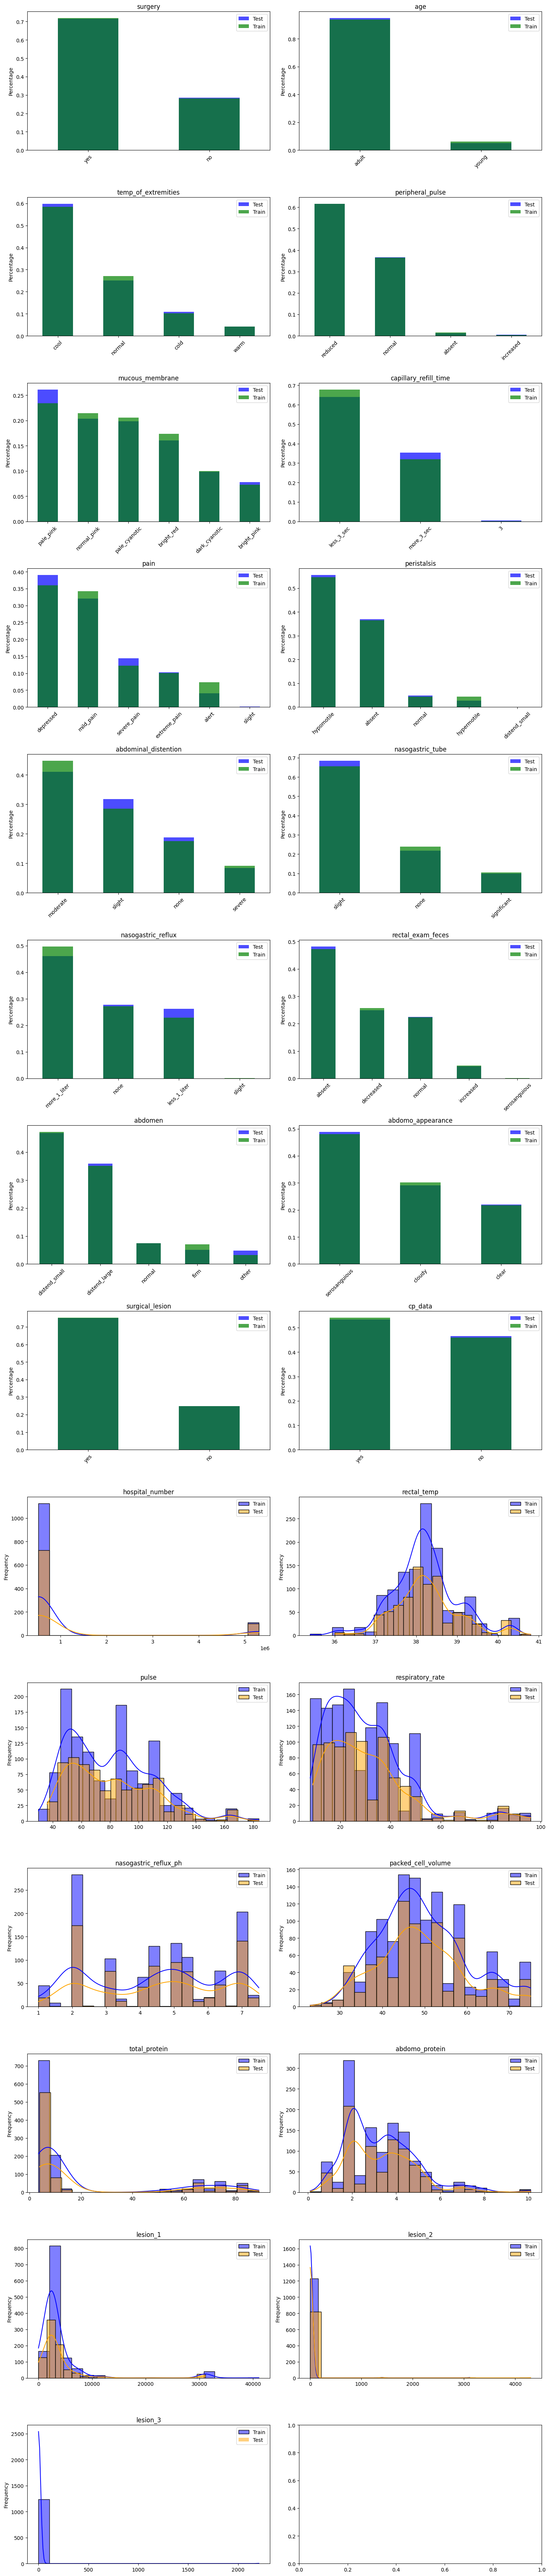

In [151]:
# Separating Categorical and Numeric Variables
categorical_columns = train_data.drop(columns='outcome').select_dtypes(include=['object']).columns
numeric_columns = train_data.select_dtypes(include=['int64', 'float64']).columns

# Plotting all subplots
num_numeric_cols = len(numeric_columns)
num_categorical_cols = len(categorical_columns)
num_cols = num_numeric_cols + num_categorical_cols
num_rows = (num_cols // 2) + (num_cols % 2)

fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
fig.subplots_adjust(hspace=0.5)

# Categorical Variables
for i, col in enumerate(categorical_columns):
    ax = axes[i // 2, i % 2]
    test_data[col].value_counts(normalize=True).plot(kind='bar', ax=ax, color='blue', alpha=0.7, label='Test')
    train_data[col].value_counts(normalize=True).plot(kind='bar', ax=ax, color='green', alpha=0.7, label='Train')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Percentage')
    ax.tick_params(axis='x', rotation=45)  
    ax.legend()

# Numeric Variables with kernel density estimate in blue
for i, col in enumerate(numeric_columns):
    ax = axes[(i + num_categorical_cols) // 2, (i + num_categorical_cols) % 2]
    sns.histplot(train_data[col], bins=20, kde=True, color='blue', ax=ax, label='Train')
    sns.histplot(test_data[col], bins=20, kde=True, color='orange', ax=ax, label='Test')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()


Data in the training and testing sets exhibit similar variations, it doesn't seem to be any significant data drift, which suggests that the data distribution in the testing set remains consistent with the training set.

Regarding the categorical variables, they can be easily converted into numeric formats. Binary categorical variables (e.g., 'yes' and 'no') can be directly converted into binary (1 and 0) format. For other categorical variables with more than two categories, they can be effectively transformed using techniques like Label Encoding, which assigns a unique numeric label to each category. This preprocessing step makes the data suitable for machine learning algorithms that require numeric input.

First, let's see the distribution of the target variable ('outcome').

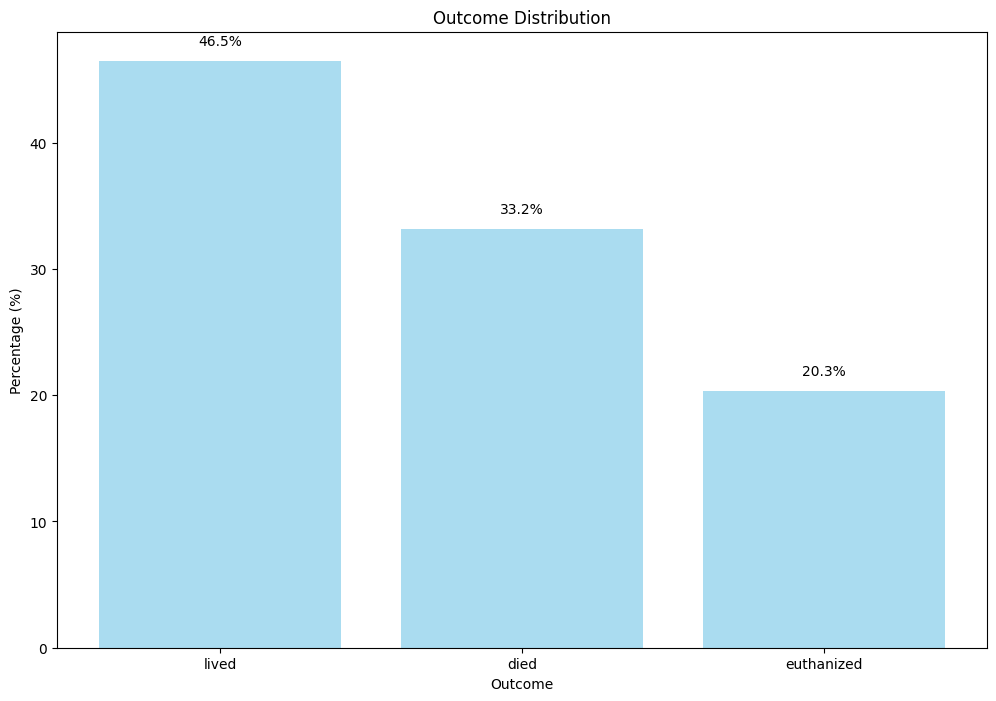

In [152]:
# Calculate the percentages
outcome_percentages = train_data['outcome'].value_counts(normalize=True) * 100

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.bar(outcome_percentages.index, outcome_percentages, color='skyblue', alpha=0.7)

plt.xlabel('Outcome')
plt.ylabel('Percentage (%)')
plt.title('Outcome Distribution')

# Display percentages on top of bars
for i, percentage in enumerate(outcome_percentages):
    plt.text(i, percentage + 1, f'{percentage:.1f}%', ha='center', va='bottom')

plt.show()


Less than 50% of the horses in this dataset have survived and approximately 20% had to be euthanized, highlighting the severity of some health issues they faced. 

**Categorical variables should be converted into numeric variables** so that the machine learning model can work with them effectively. This conversion is necessary because most ML algorithms are based on mathematical equations, and they require numerical input data. Converting categorical variables into numeric format allows the model to process and learn from these variables, making it possible to include them in the modeling process. There are various techniques for encoding categorical variables into numeric representations, such as one-hot encoding, label encoding, or ordinal encoding, depending on the nature of the categorical data and the specific requirements of the model.

**One-hot Encoding**

In [153]:
# Perform one-hot encoding for binary variables
train_data = pd.get_dummies(train_data, 
                            columns = ['surgery', 'age', 'surgical_lesion', 'cp_data'], 
                            drop_first = True)

test_data = pd.get_dummies(test_data, 
                           columns = ['surgery', 'age', 'surgical_lesion', 'cp_data'], 
                           drop_first = True)



In [154]:
# Converting True/False into 1/0
binary_columns = ['surgery_yes', 'age_young', 'surgical_lesion_yes', 'cp_data_yes']

train_data[binary_columns] = train_data[binary_columns].astype(int)
test_data[binary_columns] = test_data[binary_columns].astype(int)

In [155]:
train_data.isnull().sum()

hospital_number            0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities       39
peripheral_pulse          60
mucous_membrane           21
capillary_refill_time      6
pain                      44
peristalsis               20
abdominal_distention      23
nasogastric_tube          80
nasogastric_reflux        21
nasogastric_reflux_ph      0
rectal_exam_feces        190
abdomen                  213
packed_cell_volume         0
total_protein              0
abdomo_appearance         48
abdomo_protein             0
lesion_1                   0
lesion_2                   0
lesion_3                   0
outcome                    0
surgery_yes                0
age_young                  0
surgical_lesion_yes        0
cp_data_yes                0
dtype: int64

In [156]:
test_data.isnull().sum()

hospital_number            0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities       35
peripheral_pulse          47
mucous_membrane           13
capillary_refill_time      6
pain                      29
peristalsis               19
abdominal_distention      22
nasogastric_tube          64
nasogastric_reflux        14
nasogastric_reflux_ph      0
rectal_exam_feces        125
abdomen                  154
packed_cell_volume         0
total_protein              0
abdomo_appearance         31
abdomo_protein             0
lesion_1                   0
lesion_2                   0
lesion_3                   0
surgery_yes                0
age_young                  0
surgical_lesion_yes        0
cp_data_yes                0
dtype: int64

**Ordinal Encoder**

In [157]:
# categorical variables to be encoded
cat_col_to_encode = ['temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 
                     'capillary_refill_time', 'pain', 'peristalsis',
                     'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
                     'rectal_exam_feces', 'abdomen', 'abdomo_appearance']


# Create an imputer with the strategy 'most_frequent' (mode)
imputer = SimpleImputer(strategy = 'most_frequent')

# Fit and transform the values in the training data for categorical columns
train_data[cat_col_to_encode] = imputer.fit_transform(train_data[cat_col_to_encode])

# Transform the values in the test data using the same imputer for categorical columns
test_data[cat_col_to_encode] = imputer.transform(test_data[cat_col_to_encode])


# Create an OrdinalEncoder with specified handle_unknown and unknown_value
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10)

# Fit and transform the values in the training data for categorical columns
train_data[cat_col_to_encode] = encoder.fit_transform(train_data[cat_col_to_encode])

# Transform the values in the test data using the same encoder for categorical columns
test_data[cat_col_to_encode] = encoder.transform(test_data[cat_col_to_encode])


**Target Variable: 'outcome'**

The target variable is also categorical and machine learning models typically require numeric input. Therefore, it was converted into a numeric format.

In [158]:
# Dealing with the target variable
categories = [['died', 'euthanized', 'lived']]
encoder = OrdinalEncoder(categories = categories)

train_data['outcome'] = encoder.fit_transform(train_data[['outcome']])

In [159]:
train_data['outcome'] = train_data['outcome'].astype(int)

train_data['outcome'].unique()

array([0, 1, 2])

In [160]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1235 entries, 0 to 1234
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   hospital_number        1235 non-null   int64  
 1   rectal_temp            1235 non-null   float64
 2   pulse                  1235 non-null   float64
 3   respiratory_rate       1235 non-null   float64
 4   temp_of_extremities    1235 non-null   float64
 5   peripheral_pulse       1235 non-null   float64
 6   mucous_membrane        1235 non-null   float64
 7   capillary_refill_time  1235 non-null   float64
 8   pain                   1235 non-null   float64
 9   peristalsis            1235 non-null   float64
 10  abdominal_distention   1235 non-null   float64
 11  nasogastric_tube       1235 non-null   float64
 12  nasogastric_reflux     1235 non-null   float64
 13  nasogastric_reflux_ph  1235 non-null   float64
 14  rectal_exam_feces      1235 non-null   float64
 15  abdomen  

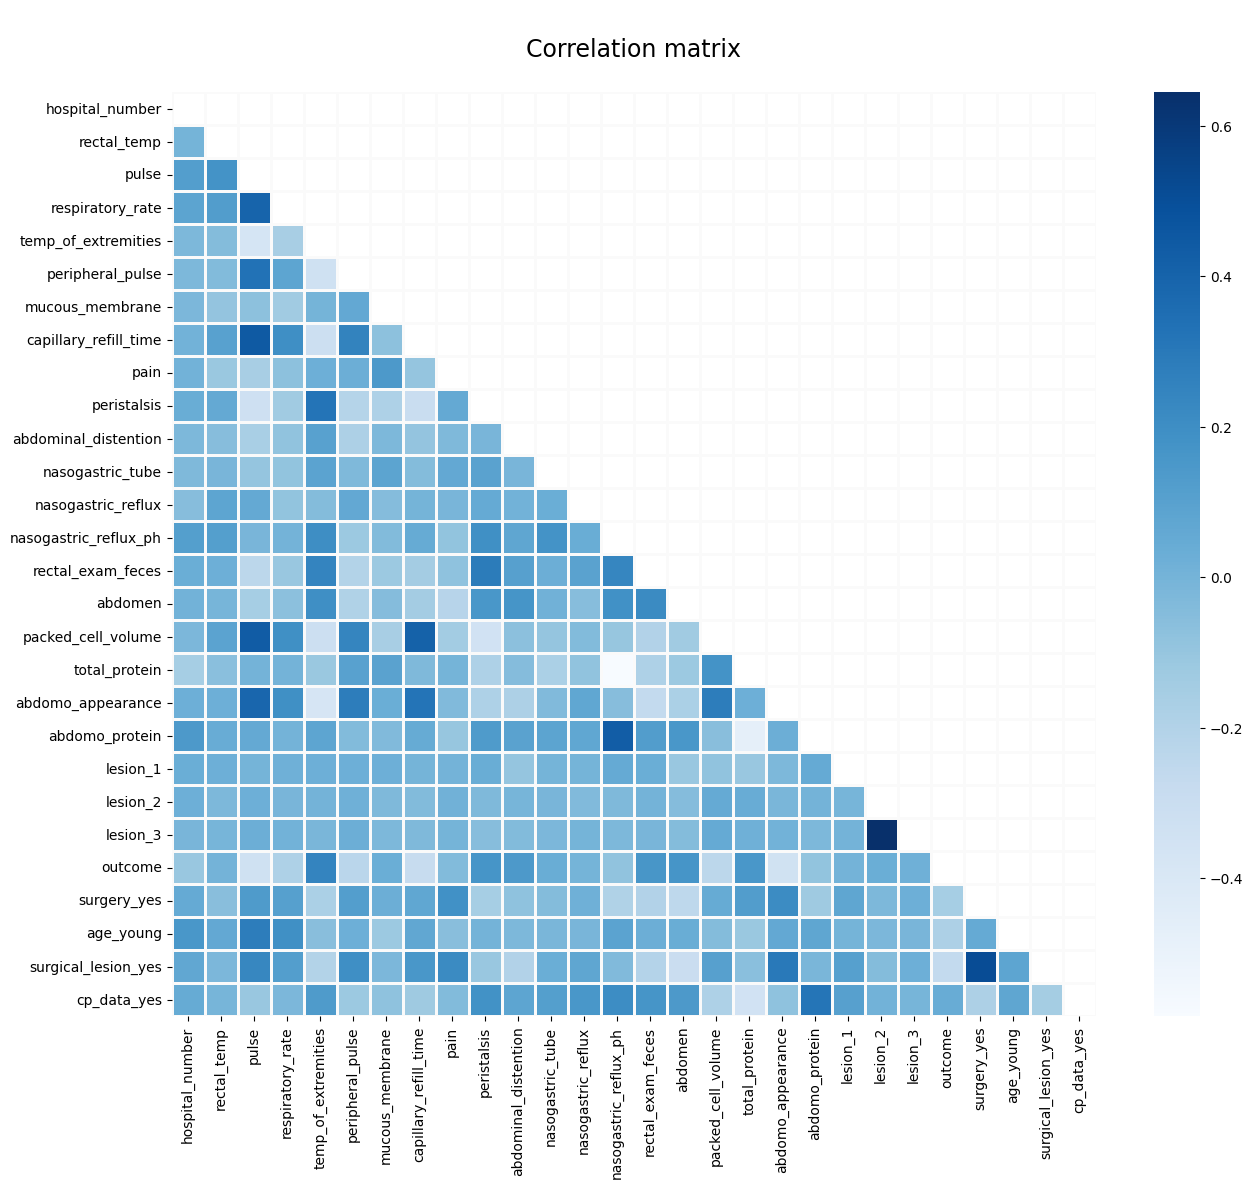

In [161]:
corr_matrix = train_data.select_dtypes(include=np.number).corr()
mask = np.triu(corr_matrix)

plt.figure(figsize=(15,12))
sns.heatmap(data=corr_matrix, 
            mask=mask, 
            cmap='Blues', 
            linewidths=1, 
            square=True, 
            linecolor='#fafafa')

plt.title('\nCorrelation matrix\n', fontsize=17)
plt.show()

In [162]:
train_data

,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,...,abdomo_appearance,abdomo_protein,lesion_1,lesion_2,lesion_3,outcome,surgery_yes,age_young,surgical_lesion_yes,cp_data_yes
id,,,,,,,,,,,,,,,,,,,,,
0,530001,38.1,132.0,24.0,1.0,3.0,2.0,2.0,1.0,0.0,...,2.0,3.4,2209,0,0,0,1,0,1,0
1,533836,37.5,88.0,12.0,1.0,2.0,4.0,2.0,3.0,0.0,...,2.0,2.0,2208,0,0,1,1,0,1,0
2,529812,38.3,120.0,28.0,1.0,3.0,5.0,1.0,2.0,3.0,...,2.0,3.4,5124,0,0,2,1,0,1,0
3,5262541,37.1,72.0,30.0,0.0,3.0,5.0,2.0,3.0,3.0,...,1.0,3.9,2208,0,0,2,1,0,1,1
4,5299629,38.0,52.0,48.0,2.0,2.0,3.0,1.0,0.0,3.0,...,1.0,2.6,0,0,0,2,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,535246,38.5,129.0,48.0,1.0,3.0,5.0,2.0,1.0,0.0,...,2.0,2.0,2206,0,0,2,1,0,1,0
1231,528570,37.5,60.0,50.0,1.0,3.0,4.0,1.0,3.0,3.0,...,2.0,3.6,2209,0,0,0,1,0,1,1
1232,529685,37.5,84.0,40.0,2.0,3.0,3.0,1.0,3.0,3.0,...,1.0,7.0,400,0,0,2,1,1,1,1


# Modeling


Now that we have completed the handling of missing values and the encoding of categorical variables, we can commence the data modeling process. I have chosen to utilize XGBoost for this task, as it is a robust model well-suited for dealing with non-Gaussian data distributions. In this dataset, many of our variables do not adhere to a normal distribution.

XGBoost is renowned for its ability to perform effectively even when the data distribution deviates from the normal. This makes it an ideal choice for our modeling objectives.

In [163]:
# Split the data 
X = train_data.drop('outcome', axis=1)  
y = train_data['outcome'] 

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)


In [164]:
model = XGBClassifier(objective = 'multi:softmax',
                      eval_metric = 'logloss',
                      random_state = 42
                     )

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None, ...)

In [165]:
# Making predictions
y_pred = model.predict(X_test)

In [166]:
df = pd.DataFrame({'Real Outcome': y_test,'Predictions':y_pred })
df.head()

,Real Outcome,Predictions
id,,
753,1,1
582,1,1
548,0,0
113,1,2
174,2,2


In [167]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.680161943319838



This accuracy indicates that the model can only make correct predictions for approximately 68% of the data. Let's proceed to tune the model by searching for the best hyperparameters.

In [168]:
# Defining the best hyperparameters to optimize
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  
    'max_depth': [3, 4, 5],  
    'n_estimators': [50, 100, 200],  
    'subsample': [0.8, 0.9, 1.0],  
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# XGBoost Model
model = XGBClassifier(objective = 'binary:logistic', 
                      eval_metric = 'logloss', 
                      random_state = 42)

# GridSearchCV 
grid_search = GridSearchCV(estimator = model, 
                           param_grid = param_grid, 
                           cv = 3, 
                           scoring = 'accuracy', 
                           n_jobs = -1)

# Fit GridSearchCV to training set 
grid_search.fit(X_train, y_train)

# Best Hyperparameters
print('Best Hyperparameters: ', grid_search.best_params_)

# The best model obtained with GridSearchCV
best_model = grid_search.best_estimator_

# Accuracy
accuracy = best_model.score(X_test, y_test)
print('Accuracy from Best Model: ', accuracy)


Best Hyperparameters:  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Accuracy from Best Model:  0.708502024291498


In [169]:
train_data.columns

Index(['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate',
       'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane',
       'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention',
       'nasogastric_tube', 'nasogastric_reflux', 'nasogastric_reflux_ph',
       'rectal_exam_feces', 'abdomen', 'packed_cell_volume', 'total_protein',
       'abdomo_appearance', 'abdomo_protein', 'lesion_1', 'lesion_2',
       'lesion_3', 'outcome', 'surgery_yes', 'age_young',
       'surgical_lesion_yes', 'cp_data_yes'],
      dtype='object')

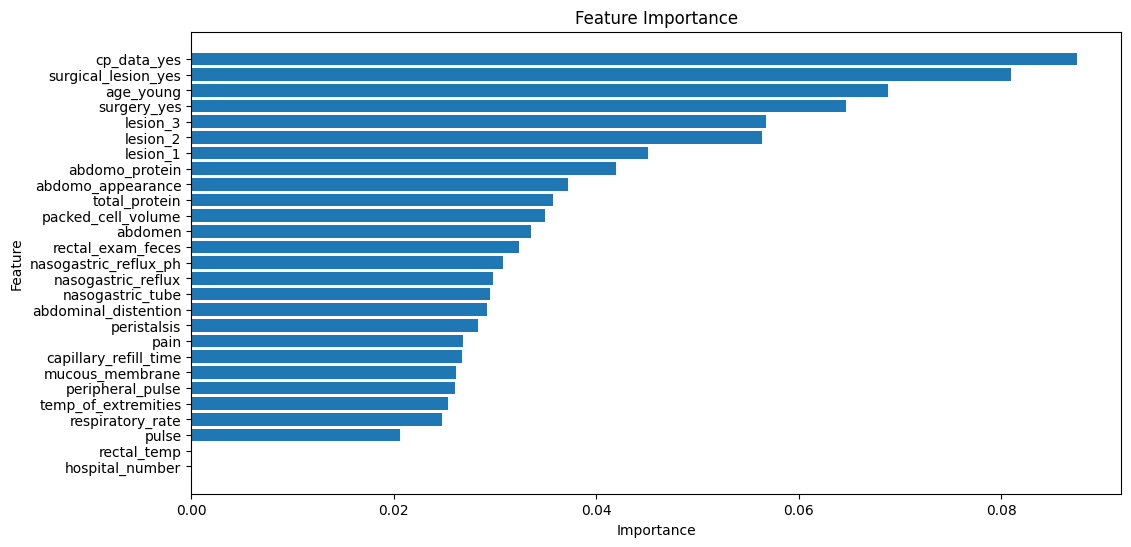

In [170]:
importances = best_model.feature_importances_
sorted_idx = importances.argsort()

# Crating a Data Frame with the feartures in the training set 
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Creating the Feature importance Table
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'],
         importances[sorted_idx]
        )

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

plt.show()


## Second XGBoost

In this second model, I have removed the less important features: 'rectal_temp' and 'hospital_number'.

In [171]:
# Split the data 
X = train_data.drop(columns={'outcome','rectal_temp','hospital_number'}, axis=1)  
y = train_data['outcome'] 

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)


In [172]:
# Define the model with custom parameters
model_1 = XGBClassifier(
                        objective='multi:softmax',
                        eval_metric='logloss',
                        random_state=42,
                        colsample_bytree=0.9,
                        learning_rate=0.1,
                        max_depth=4,
                        n_estimators=100,
                        subsample=0.8
                        )

# Fit the model to training data
model_1.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', predictor=None, ...)

In [173]:
# Making predictions
y_pred = model_1.predict(X_test)

In [174]:
df = pd.DataFrame({'Real Outcome': y_test,'Predictions':y_pred })
df.head()

,Real Outcome,Predictions
id,,
753,1,1
582,1,1
548,0,0
113,1,1
174,2,2


In [175]:
print(df['Real Outcome'].value_counts())
print(df['Predictions'].value_counts())

Real Outcome
2    121
0     72
1     54
Name: count, dtype: int64
Predictions
2    127
0     78
1     42
Name: count, dtype: int64


In [176]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7246963562753036


In [177]:
# Hyperparameter to optimize
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  
    'max_depth': [3, 4, 5, 6],  
    'n_estimators': [50, 100, 200, 250],  
    'subsample': [0.8, 0.9, 1.0],  
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# XGBoost Model
model_1 = XGBClassifier(objective='binary:logistic', 
                        eval_metric='logloss', 
                        random_state=42)

# GridSearchCV 
grid_search = GridSearchCV(estimator = model_1, 
                           param_grid = param_grid, 
                           cv = 3, 
                           scoring = 'accuracy', 
                           n_jobs = -1)

# Fit GridSearchCV to training set 
grid_search.fit(X_train, y_train)

# Best Hyperparameters
print('Best Hyperparameters: ', grid_search.best_params_)

# The best model obtained with GridSearchCV
best_model_1 = grid_search.best_estimator_

# Accuracy
accuracy = best_model_1.score(X_test, y_test)
print('Accuracy from Best Model: ', accuracy)


Best Hyperparameters:  {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.8}
Accuracy from Best Model:  0.7327935222672065


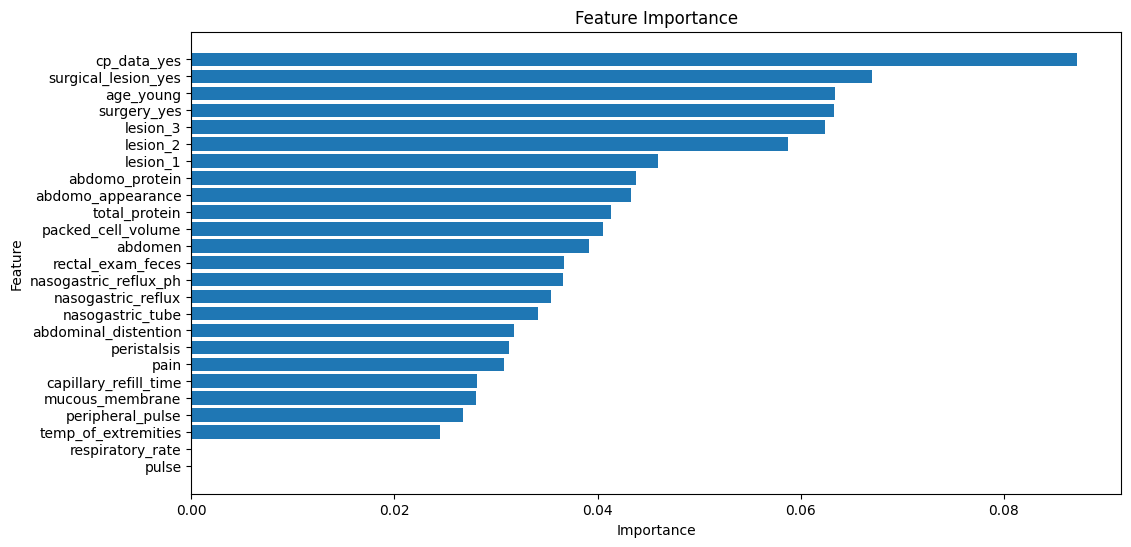

In [178]:
importances = best_model_1.feature_importances_
sorted_idx = importances.argsort()

# Crating a Data Frame with the feartures in the training set 
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Creating the Feature importance Table
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'],
         importances[sorted_idx]
        )

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

plt.show()


In [179]:
y_pred = best_model_1.predict(X_test)
df = pd.DataFrame({'Real Outcome': y_test,'Predictions':y_pred })
df

,Real Outcome,Predictions
id,,
753,1,1
582,1,1
548,0,0
113,1,1
174,2,2
...,...,...
31,0,0
778,0,2
910,0,2


In [180]:
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.74      0.68        72
           1       0.84      0.67      0.74        54
           2       0.77      0.76      0.77       121

    accuracy                           0.73       247
   macro avg       0.74      0.72      0.73       247
weighted avg       0.74      0.73      0.73       247



*Precision* is a measure of how many of the predicted positive instances were actually positive.

*Recall* is a measure of how many of the actual positive instances were correctly predicted as positive.

*The F1-score* is the harmonic mean of precision and recall and provides a balance between the two metrics. 

*Accuracy* is the overall correctness of the model's predictions

*Support* is the number of actual occurrences of each class in the test dataset.

*The macro average* is the unweighted average of precision, recall, and F1-score across all classes.

*The weighted average* is the average of precision, recall, and F1-score, weighted by the support for each class. It provides a more accurate representation of overall model performance when dealing with imbalanced datasets.

In [181]:
print(df['Real Outcome'].value_counts())
print(df['Predictions'].value_counts())

Real Outcome
2    121
0     72
1     54
Name: count, dtype: int64
Predictions
2    119
0     85
1     43
Name: count, dtype: int64


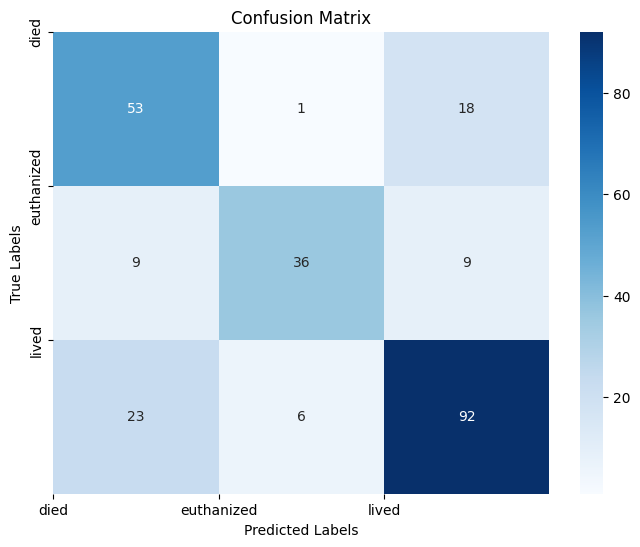

In [182]:
# Define the class names
class_names = ['died', 'euthanized', 'lived']

# Calculate Confusion Matrix
confusion_mtx = confusion_matrix(df['Real Outcome'].values, 
                                 df['Predictions'].values
                                )

# Plot the Confusion Matrix with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')

# Set custom labels for the axes
plt.xticks(np.arange(len(class_names)), 
           class_names 
           )

plt.yticks(np.arange(len(class_names)), 
           class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()


# Prediction

Now, let's apply this model to the test data in order to generate the final submission.

In [183]:
test_data.drop(columns=['rectal_temp','hospital_number'], axis = 1, inplace = True )

In [184]:
# Make predictions on the test data
test_predictions = best_model_1.predict(test_data)

# Submission
test_data.reset_index(inplace = True)

submission = pd.DataFrame({'id': test_data['id'], 'Outcome': test_predictions})

submission['Outcome']  = submission['Outcome'].map({ 0: 'died',
                                                     1: 'euthanized',
                                                     2: 'lived'
                                                    })

submission.to_csv('submission.csv', index = False)

submission.head()

,id,Outcome
0,1235,lived
1,1236,died
2,1237,lived
3,1238,euthanized
4,1239,lived
